# Анализ системы метрик приложения

Вы — продуктовый аналитик приложения Procrastinate Pro+, которое предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

Ваши задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

В вашем распоряжении есть данные о посещениях приложения, покупках и расходах на маркетинг.
Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных

Загрузите данные и получите основную информацию о них. Проведите необходимую предобработку. Основную информацию о данных и предобработке зафиксируйте в кратком промежуточном выводе.

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_visits = pd.read_csv('ppro_visits', parse_dates=['session_start','session_end'])
df_orders = pd.read_csv('ppro_orders',parse_dates=['event_dt'])
df_costs = pd.read_csv('ppro_costs',parse_dates=['dt']) 

In [69]:
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  object        
 2   device         161865 non-null  object        
 3   channel        161865 non-null  object        
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 7.4+ MB


In [70]:
(pd.DataFrame({'Количество пропусков': df_visits.isnull().sum(), 
               'Доля пропусков': df_visits.isnull().mean().round(4), 
               'Количество дубликатов': df_visits.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
user_id,0,0.000000,0
region,0,0.000000,0
device,0,0.000000,0
channel,0,0.000000,0
session_start,0,0.000000,0
session_end,0,0.000000,0


In [71]:
print(f'Количество неявных дубликатов: {df_visits.duplicated(subset= df_visits.columns[:]).sum()}')


Количество неявных дубликатов: 0


In [72]:
print(f'Интервал дат в датасете df_visits: с {min(df_visits['session_start'].dt.date)} по {max(df_visits['session_start'].dt.date)}')

Интервал дат в датасете df_visits: с 2024-04-01 по 2024-11-30


In [73]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 794.5 KB


In [74]:
(pd.DataFrame({'Количество пропусков': df_orders.isnull().sum(), 
               'Доля пропусков': df_orders.isnull().mean().round(4), 
               'Количество дубликатов': df_orders.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
user_id,0,0.000000,0
event_dt,0,0.000000,0
revenue,0,0.000000,0


In [75]:
print(f'Количество неявных дубликатов: {df_orders.duplicated(subset= df_orders.columns[:]).sum()}')


Количество неявных дубликатов: 0


In [76]:
print(f'Интервал дат в датасете df_orders: с {min(df_orders['event_dt'].dt.date)} по {max(df_orders['event_dt'].dt.date)}')

Интервал дат в датасете df_orders: с 2024-04-01 по 2024-11-30


In [77]:
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       976 non-null    datetime64[ns]
 1   channel  976 non-null    object        
 2   costs    976 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.0+ KB


In [78]:
(pd.DataFrame({'Количество пропусков': df_costs.isnull().sum(), 
               'Доля пропусков': df_costs.isnull().mean().round(4), 
               'Количество дубликатов': df_costs.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
dt,0,0.000000,0
channel,0,0.000000,0
costs,0,0.000000,0


In [79]:
print(f'Количество неявных дубликатов: {df_orders.duplicated(subset= df_orders.columns[:]).sum()}')


Количество неявных дубликатов: 0


In [80]:
print(f'Источники привлечения df_visits: {df_visits['channel'].unique()}')
print(f'Источники привлечения df_costs: {df_costs['channel'].unique()}')

Источники привлечения df_visits: ['MediaTornado' 'RocketSuperAds' 'FaceBoom' 'TipTop']
Источники привлечения df_costs: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop']


In [81]:
common_users = set(df_visits['user_id']).intersection(set(df_orders['user_id']))
print(f'Всего пользователей кто совершил покупку: {df_orders['user_id'].nunique()} и все эти {len(common_users)}, есть в датасете df_visits')

Всего пользователей кто совершил покупку: 6889 и все эти 6889, есть в датасете df_visits


Ознакомившись с датасетом `df_visits`, можно сказать, что данные соответствуют описанию. 
- У нас есть 161865 строк и 6 столбцов.
- Типы данных int64(1), object(5).
- Столбец `session_start` и `session_end`, нужно привести в типу дат.

Ознакомившись с датасетом `df_orders`, можно сказать, что данные соответствуют описанию. 
- У нас есть 33893 строк и 3 столбцов.
- Типы данных int64(1), object(1), float64(1).
- Столбец `event_dt`, нужно привести в типу дат.

Ознакомившись с датасетом `df_costs`, можно сказать, что данные соответствуют описанию. 
- У нас есть 976 строк и 3 столбцов.
- Типы данных object(2), float64(1).
- Столбец `dt`, нужно привести в типу дат.

Интервал дат в датасете `df_visits` и `df_orders`: с 2024-04-01 по 2024-11-30. Интервалы совпадают.
Источники привлечения `df_visits` и `df_costs`: ['MediaTornado' 'RocketSuperAds' 'FaceBoom' 'TipTop']. Источники совпадают.
Всего пользователей кто совершил покупку: 6889 и все эти 6889, есть в датасете `df_visits`

В остальном на первый взгляд, все хорошо.

## Подготовка данных к когортному анализу

Подготовьте данные к когортному анализу с учётом того, что вы будете изучать окупаемость привлечения пользователей за первые 28 дней.

Для каждого пользователя найдите:
- дату первой сессии (дата привлечения пользователя, `first_dt`);
- канал привлечения (`first_channel`);
- стоимость привлечения пользователя (`cac`).

Результаты сохраните в новой таблице, например, `profiles`.

Добавьте к данным с событиями и покупками информацию о первом источнике привлечения и дату привлечения пользователя из созданной таблицы. После этого рассчитайте дневной лайфтайм для каждого события или покупки и добавьте в таблицу в виде целого числа. В дальнейшем при проведении когортного анализа используйте информацию о первом источнике привлечения пользователя.

In [82]:
# Шаг 1: Находим дату и канал первой сессии
first_session = df_visits.sort_values(by= 'session_start').groupby('user_id').agg(
    first_dt=('session_start', 'min'),
    first_channel=('channel', 'first')
).reset_index()

first_session['first_dt'] = first_session['first_dt'].dt.normalize()

In [83]:
# Шаг 2: Рассчитываем стоимость привлечения (CAC)
day_costs = df_costs.groupby(['dt', 'channel']).agg(
    total_costs=('costs', 'sum')
).reset_index()

# Находим количество привлеченных пользователей по дням и каналам
new_users = first_session.groupby(['first_dt', 'first_channel']).agg(
    users_count=('user_id', 'nunique')
).reset_index()

new_users = new_users.merge(day_costs, 
    left_on= ['first_dt', 'first_channel'],
    right_on= ['dt', 'channel'],
    how= 'inner')
# Объединяем данные и рассчитываем CAC
new_users['cac'] = day_costs['total_costs'] / new_users['users_count']
new_users = new_users[['first_channel', 'first_dt', 'total_costs', 'users_count', 'cac']].sort_values(by= ['first_channel', 'first_dt'])

In [84]:
first_session = (first_session.merge(new_users[['first_dt','first_channel','cac']],
                            on=['first_dt','first_channel'],
                            how='left'))

In [85]:
visits = df_visits.merge(first_session[['user_id','first_dt','first_channel']], on='user_id', how='left')
orders = df_orders.merge(first_session[['user_id','first_dt','first_channel']], on='user_id', how='left')

visits['lifetime'] = (visits['session_start'] - visits['first_dt']).dt.days.astype('int')
orders['lifetime'] = (orders['event_dt'] - orders['first_dt']).dt.days.astype('int')

In [86]:
# Оставляем только первые 28 дней
orders_28 = orders[orders['lifetime'] < 28].copy()
visits_28 = visits[visits['lifetime'] < 28].copy()

In [87]:
orders_28.head()

,user_id,event_dt,revenue,first_dt,first_channel,lifetime
0,771951256319,2024-04-01 05:56:26,2.99,2024-04-01,FaceBoom,0
1,829942381059,2024-04-01 14:55:02,2.99,2024-04-01,FaceBoom,0
2,727879856738,2024-04-01 22:15:09,14.99,2024-04-01,FaceBoom,0
3,481270888930,2024-04-01 06:05:14,2.99,2024-04-01,TipTop,0
4,844695029762,2024-04-01 01:19:52,2.99,2024-04-01,FaceBoom,0


In [88]:
orders_28.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21424 entries, 0 to 33892
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        21424 non-null  int64         
 1   event_dt       21424 non-null  datetime64[ns]
 2   revenue        21424 non-null  float64       
 3   first_dt       21424 non-null  datetime64[ns]
 4   first_channel  21424 non-null  object        
 5   lifetime       21424 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(1)
memory usage: 1.1+ MB


In [89]:
(pd.DataFrame({'Количество пропусков': orders_28.isnull().sum(), 
               'Доля пропусков': orders_28.isnull().mean().round(4), 
               'Количество дубликатов': orders_28.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
user_id,0,0.000000,0
event_dt,0,0.000000,0
revenue,0,0.000000,0
first_dt,0,0.000000,0
first_channel,0,0.000000,0
lifetime,0,0.000000,0


In [90]:
print(f'Количество неявных дубликатов: {orders_28.duplicated(subset= orders_28.columns[:]).sum()}')


Количество неявных дубликатов: 0


In [91]:
visits_28.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel,lifetime
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00,2024-04-01,MediaTornado,0
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00,2024-04-01,RocketSuperAds,0
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00,2024-04-01,MediaTornado,0
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00,2024-04-01,MediaTornado,0
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00,2024-04-01,RocketSuperAds,0


In [92]:
visits_28.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140581 entries, 0 to 161864
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        140581 non-null  int64         
 1   region         140581 non-null  object        
 2   device         140581 non-null  object        
 3   channel        140581 non-null  object        
 4   session_start  140581 non-null  datetime64[ns]
 5   session_end    140581 non-null  datetime64[ns]
 6   first_dt       140581 non-null  datetime64[ns]
 7   first_channel  140581 non-null  object        
 8   lifetime       140581 non-null  int32         
dtypes: datetime64[ns](3), int32(1), int64(1), object(4)
memory usage: 10.2+ MB


In [93]:
(pd.DataFrame({'Количество пропусков': visits_28.isnull().sum(), 
               'Доля пропусков': visits_28.isnull().mean().round(4), 
               'Количество дубликатов': visits_28.duplicated().sum()}).style.background_gradient(cmap='coolwarm'))

,Количество пропусков,Доля пропусков,Количество дубликатов
user_id,0,0.000000,0
region,0,0.000000,0
device,0,0.000000,0
channel,0,0.000000,0
session_start,0,0.000000,0
session_end,0,0.000000,0
first_dt,0,0.000000,0
first_channel,0,0.000000,0
lifetime,0,0.000000,0


In [94]:
print(f'Количество неявных дубликатов: {visits_28.duplicated(subset= visits_28.columns[:]).sum()}')


Количество неявных дубликатов: 0


In [95]:
common_users = set(visits_28['user_id']).intersection(set(orders_28['user_id']))
print(f'Всего пользователей кто совершил покупку: {orders_28['user_id'].nunique()} и все эти {len(common_users)}, есть в датасете visits')

Всего пользователей кто совершил покупку: 6834 и все эти 6834, есть в датасете visits


Подготовили данные к когортному анализу, все объединения прошли успешно. Пропусков нет, дубликатов тоже. Во время подготовки данных, количество платящих пользователей уменьшилось на 55 человек. В остальном всё хорошо, данные готовы к дальнейшей работе.

Наши категориальные признаки готовы для дальнейшего анализа и моделирования. Неявных дубликатов нет. Важно помнить, что качество дальнейшей аналитики зависит от чистоты и правильности представленных данных.


## Анализ месячной динамики основных метрик продукта

**Задача 1**. Начните анализ данных с изучения динамики активности пользователей и их вовлечённости в продукт. Рассчитайте по всем данным значения DAU, MAU и Stickiness и визуализируйте их. Активными считайте всех пользователей, которые взаимодействовали с приложением.

**Задача 2**. В разрезе каждого месяца привлечения новых пользователей рассчитайте:
- Среднюю стоимость привлечения пользователя (CAC).
- Значение LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения.

Здесь и далее при расчёте LTV и ROI учитывайте всех привлечённых пользователей когорты.

Визуализируйте метрики и сформулируйте небольшой промежуточный вывод. Сделайте акцент на общей динамике изменения метрик с учётом появления нового контента в начале лета.

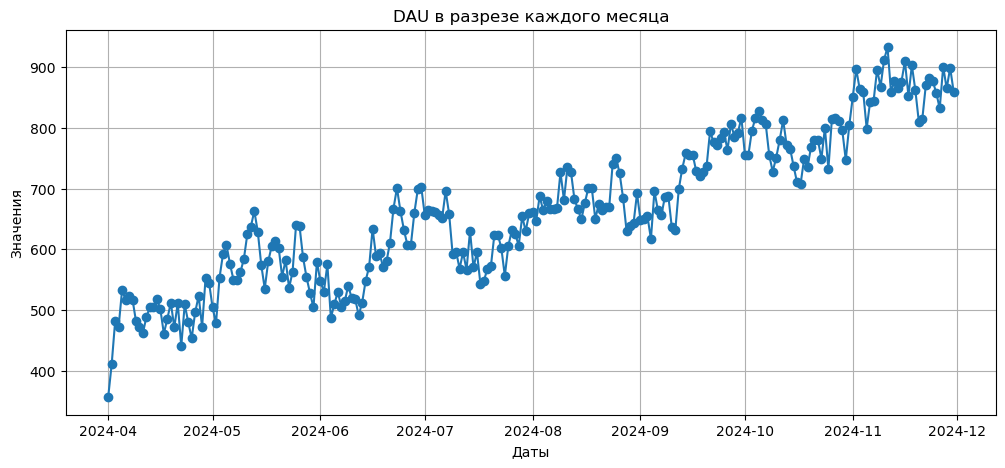

In [96]:
visits['days'] = pd.to_datetime(visits['session_start']).dt.date
dau = visits.groupby(['days'])['user_id'].nunique().reset_index()

plt.subplots(figsize=(12,5))

plt.plot(dau['days'], dau['user_id'], marker= 'o')

plt.title('DAU в разрезе каждого месяца')
plt.xlabel('Даты')
plt.ylabel('Значения')

plt.grid()
plt.show()

На основе графика можно сделать следующие выводы:
- Значения DAU (Daily Active Users) демонстрируют устойчивый рост с апреля 2024 года. Это может указывать на успешное развитие продукта или увеличение его популярности.
- В графике заметны небольшие колебания значений в пределах каждого месяца. Например, в апреле и мае наблюдается снижение, которое затем компенсируется ростом в последующие месяцы.
- Наиболее значительный рост значений DAU наблюдается в период с октября по декабрь 2024 года, что может быть связано с сезонными факторами, такими как праздники или маркетинговые кампании.

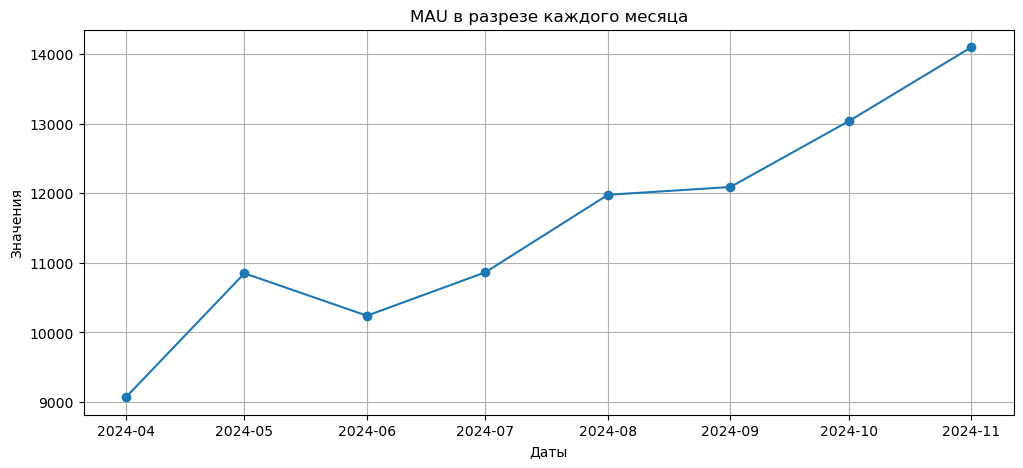

In [97]:
visits['month'] = visits['session_start'].dt.to_period('M').dt.to_timestamp()
mau = visits.groupby('month')['user_id'].nunique().reset_index()

plt.subplots(figsize=(12,5))

plt.plot(mau['month'], mau['user_id'], marker= 'o')

plt.title('MAU в разрезе каждого месяца')
plt.xlabel('Даты')
plt.ylabel('Значения')

plt.grid()
plt.show()

На основе графика можно сделать следующие выводы:
- Значения MAU (Monthly Active Users) демонстрируют устойчивый рост с апреля 2024 года. Это может указывать на успешное развитие продукта или увеличение его популярности.
- В июне 2024 года наблюдается временное снижение значений MAU, что может быть связано с сезонными факторами, например, отпусками или снижением активности пользователей.
- Наиболее значительный рост значений MAU происходит в период с октября по ноябрь 2024 года, что может быть связано с успешными маркетинговыми кампаниями или запуском новых функций.

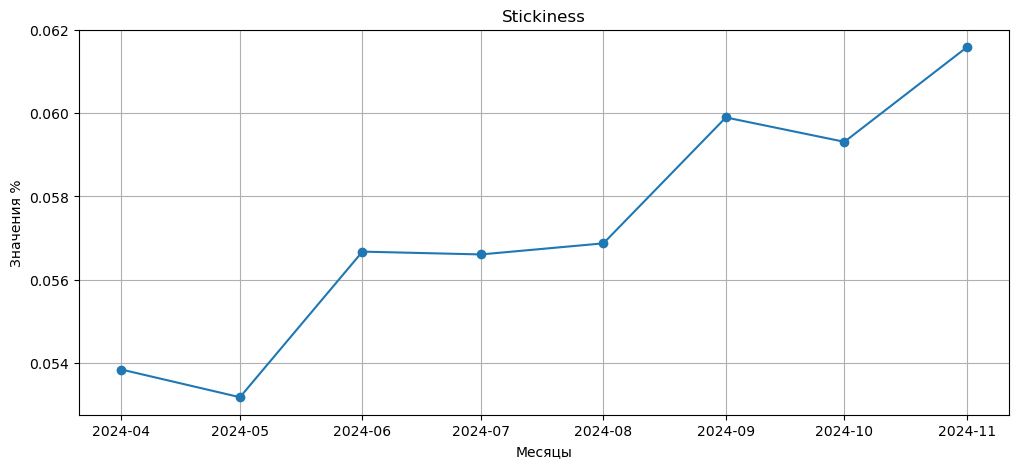

In [98]:
dau['days'] = pd.to_datetime(dau['days'])
dau['month'] = dau['days'].dt.to_period('M').dt.to_timestamp()
dau_avg = dau.groupby('month')['user_id'].mean().reset_index()

# Считаем общий Stickiness
stickiness = pd.merge(mau, dau_avg, how='left', on='month')
stickiness['stick'] = stickiness['user_id_y']/stickiness['user_id_x']

plt.subplots(figsize=(12,5))

plt.plot(stickiness['month'], stickiness['stick'], marker= 'o')

plt.title('Stickiness')
plt.xlabel('Месяцы')
plt.ylabel('Значения %')

plt.grid()
plt.show()

График показывает динамику показателя «липкость» (Sticky Factor) за период с апреля по ноябрь 2024 года.

Основные тенденции:
- В апреле значение липкости составляло около 0,054%.
-  мае произошло резкое снижение до 0,052%.
- С июня начинается устойчивый рост, который продолжается до октября.
- В октябре значение достигает пика — около 0,060%.
- В ноябре наблюдается небольшое снижение до 0,058%.

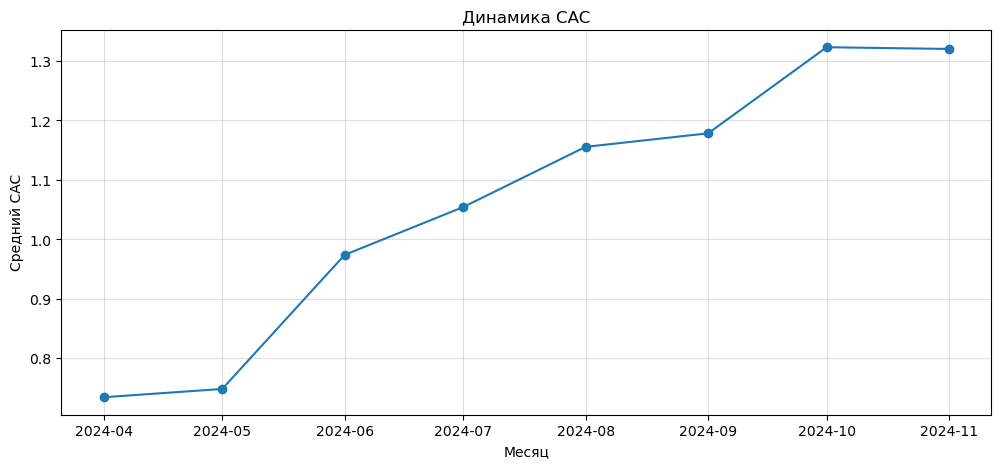

In [99]:
first_session['first_month'] = first_session['first_dt'].dt.to_period('M').dt.to_timestamp()
cac = first_session.groupby('first_month').agg(
  total_user= ('user_id', 'nunique'),
  avg_cac= ('cac', 'mean')
).reset_index()

plt.subplots(figsize=(12,5))

plt.plot(cac['first_month'], cac['avg_cac'], marker= 'o')

plt.title('Динамика CAC')
plt.xlabel('Месяц')
plt.ylabel('Средний CAC')

plt.grid(alpha=.4)
plt.show()

На графике представлена динамика среднего САС за период с апреля по ноябрь 2024 года. Вот основные выводы:

- Средний САС демонстрирует устойчивый рост на протяжении всего периода. Это может указывать на увеличение затрат на привлечение клиентов или на изменение эффективности маркетинговых каналов.

Рекомендации:

- Проанализировать эффективность рекламных каналов и перераспределить бюджет на более эффективные.
- Рассмотреть возможность оптимизации маркетинговых стратегий для снижения САС.

In [100]:
ltv = orders[orders['lifetime'] < 28].copy()

ltv['first_month'] = ltv['first_dt'].dt.to_period('M').dt.to_timestamp()

ltv = ltv.groupby(['first_month']).agg(
revenue_28 = ('revenue','sum'),
).reset_index()

ltv = ltv.merge(cac, on='first_month')

ltv['ltv_28'] = ltv['revenue_28'] / ltv['total_user']

ltv = ltv[ltv['first_month'] < "2024-11-01"]

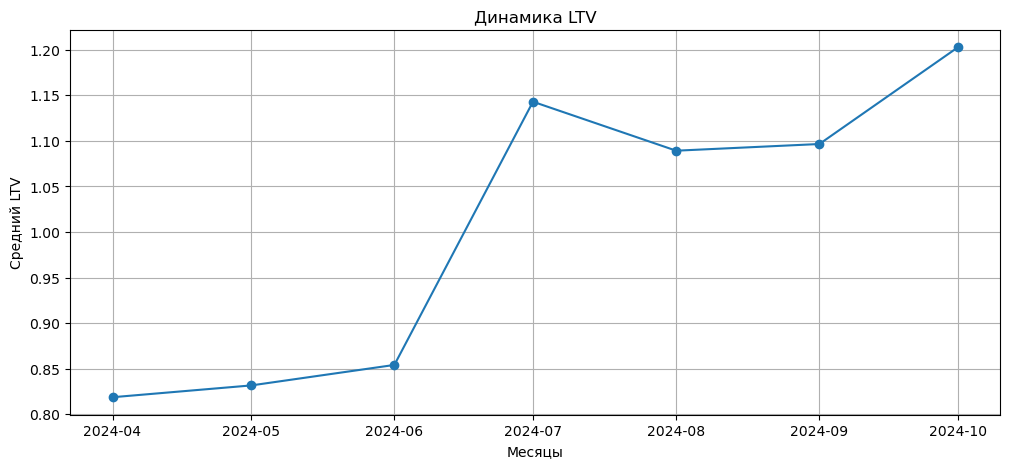

In [101]:
plt.subplots(figsize=(12,5))

plt.plot(ltv['first_month'], ltv['ltv_28'], marker= 'o')

plt.title('Динамика LTV')
plt.xlabel('Месяцы')
plt.ylabel('Средний LTV')

plt.grid()
plt.show()

На графике представлена динамика среднего LTV (Lifetime Value) за период с апреля по октябрь 2024 года. Вот основные выводы:

- Апрель 2024: Начальное значение LTV составляет около 0,80.
- Май 2024: Наблюдается небольшой рост до 0,85.
- Июнь 2024: LTV остается на уровне 0,85.
- Июль 2024: Резкий рост до 1,15, что является пиком за указанный период.
- Август 2024: Снижение до 1,05.
- Сентябрь 2024: Значение стабилизируется на уровне 1,00.
- Октябрь 2024: Рост до 1,20, что является самым высоким значением за весь период.

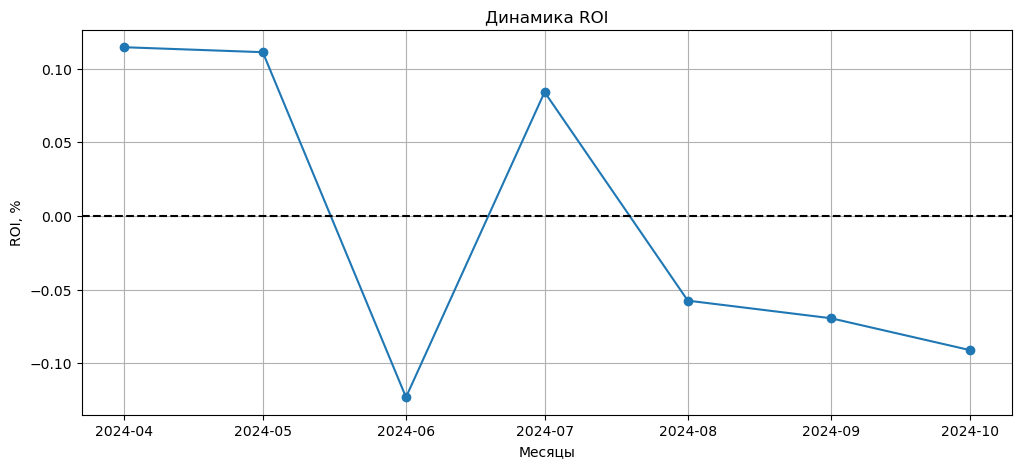

In [102]:
ltv['roi_28'] = ((ltv['ltv_28'] - ltv['avg_cac']) / ltv['avg_cac'])

plt.subplots(figsize=(12,5))

plt.plot(ltv['first_month'], ltv['roi_28'], marker= 'o')
plt.axhline(y= 0, color= 'black', linestyle= '--', label= 'Граница окупаемости')

plt.title('Динамика ROI')
plt.xlabel('Месяцы')
plt.ylabel('ROI, %')

plt.grid()
plt.show()

На графике представлена динамика ROI за период с апреля по октябрь 2024 года. Вот основные данные:

- Апрель: ROI составляет около 0,10%.
- Май: ROI остается на уровне 0,10%.
- Июнь: ROI резко падает до -0,10%.
- Июль: ROI достигает максимума в 0,10%.
- Август: ROI снижается до 0,05%.
- Сентябрь: ROI продолжает снижаться до 0,00%.
- Октябрь: ROI падает до -0,05%.

Рекомендации:
- Проанализировать причины резких колебаний в апреле и мае, чтобы понять, какие факторы влияют на ROI.
- Рассмотреть возможность оптимизации инвестиций в октябре и ноябре для предотвращения дальнейшего снижения ROI.

## Анализ метрик в разрезе источника привлечения

Теперь необходимо разобраться, какие источники привлечения перспективны, а какие за 28 дней не окупились.

**Задача 1**. Определите самые популярные источники привлечения:
- Посчитайте общее число привлечённых пользователей для каждого источника.
- Визуализируйте динамику набора новых пользователей по дням в каждом источнике.
- Рассчитайте и визуализируйте динамику DAU, MAU и Stickiness по источникам привлечения.

**Задача 2**. Изучите динамику изменения метрик на 28-й день в разрезе источника. Проведите анализ с выделением недельных когорт по дате привлечения. Рассчитайте и визуализируйте:
- Скользящее удержание на 14-й день с момента привлечения (за период с 14-го по 28-й день).
- Конверсию в покупку.

Недельную динамику затрат на маркетинг по каждому источнику привлечения.
Динамику среднего CAC, значений LTV и ROI.

По результатам проведите анализ рекламных каналов. Дайте общую характеристику каждому рекламному каналу по рассчитанным метрикам. Укажите, какие рекламные каналы не вышли на уровень окупаемости за ожидаемый период, и предположите почему.


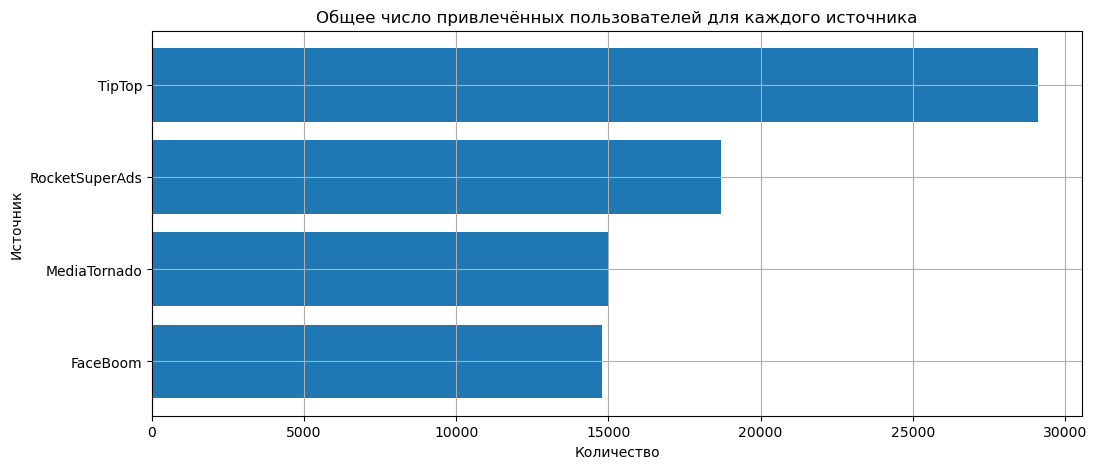

In [103]:
total_channel = visits.groupby('channel')['user_id'].nunique().reset_index()

plt.subplots(figsize= (12,5))

plt.barh(total_channel['channel'], total_channel['user_id'].sort_values())
    
plt.title('Общее число привлечённых пользователей для каждого источника')
plt.xlabel('Количество')
plt.ylabel('Источник')

plt.grid()
plt.show()

In [104]:
total_channel.head()

,channel,user_id
0,FaceBoom,29109
1,MediaTornado,14804
2,RocketSuperAds,14972
3,TipTop,18709


На основе графика можно сделать следующие выводы:
- `TipTop` является наиболее эффективным источником привлечения пользователей, с общим числом привлечённых пользователей около 30 000.
- `RocketSuperAds` занимает второе место с результатом около 25 000 пользователей.
- `MediaTornado` и `FaceBoom` показывают схожие результаты, привлекая примерно по 15 000 пользователей каждый.


In [105]:
new_users_chan = first_session.groupby(['first_dt','first_channel'])['user_id'].nunique().reset_index()


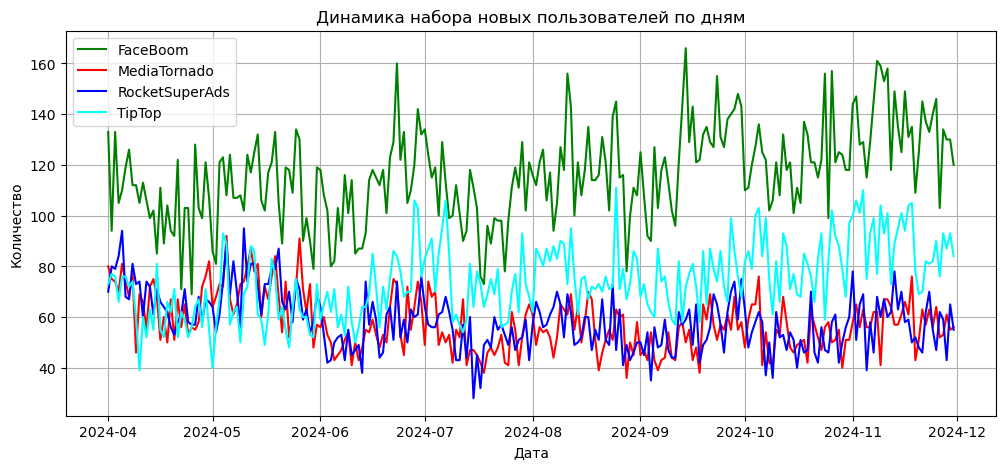

In [106]:
plt.subplots(figsize= (12, 5))

plt.plot(new_users_chan[new_users_chan['first_channel'] == 'FaceBoom']['first_dt'], new_users_chan[new_users_chan['first_channel'] == 'FaceBoom']['user_id'], color= 'green')
plt.plot(new_users_chan[new_users_chan['first_channel'] == 'MediaTornado']['first_dt'], new_users_chan[new_users_chan['first_channel'] == 'MediaTornado']['user_id'], color= 'red')
plt.plot(new_users_chan[new_users_chan['first_channel'] == 'RocketSuperAds']['first_dt'], new_users_chan[new_users_chan['first_channel'] == 'RocketSuperAds']['user_id'], color= 'blue')
plt.plot(new_users_chan[new_users_chan['first_channel'] == 'TipTop']['first_dt'], new_users_chan[new_users_chan['first_channel'] == 'TipTop']['user_id'], color= 'cyan')

plt.title('Динамика набора новых пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

График показывает динамику набора новых пользователей по дням для четырех платформ: `FaceBoom`, `MediaTornado`, `RocketSuperAds` и `TipTop`. Вот основные выводы:

`FaceBoom`:
- Стабильный рост числа новых пользователей в течение всего периода.
- Наибольшее количество новых пользователей наблюдается в июле и октябре.

`MediaTornado`:
- Количество новых пользователей колеблется, но в целом остается на среднем уровне.
- Пик активности приходится на май и сентябрь.

`RocketSuperAds`:
- Значительные колебания числа новых пользователей, особенно в апреле и августе.
- В октябре наблюдается заметный рост.

`TipTop`:
- Стабильный уровень новых пользователей с небольшими колебаниями.
- Наибольшее количество новых пользователей зафиксировано в июне и ноябре.

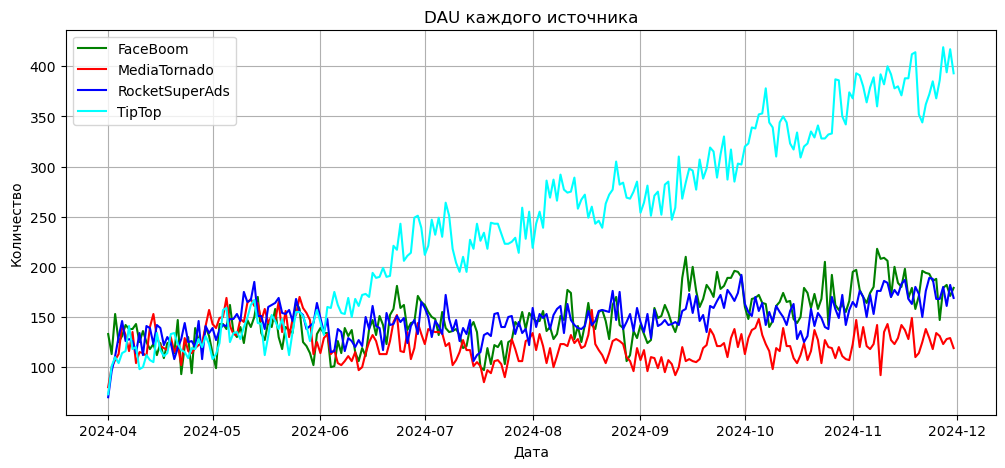

In [107]:
dau_channel = visits.groupby(['days', 'channel'])['user_id'].nunique().reset_index()

plt.subplots(figsize= (12, 5))

plt.plot(dau_channel[dau_channel['channel'] == 'FaceBoom']['days'], dau_channel[dau_channel['channel'] == 'FaceBoom']['user_id'], color= 'green')
plt.plot(dau_channel[dau_channel['channel'] == 'MediaTornado']['days'], dau_channel[dau_channel['channel'] == 'MediaTornado']['user_id'], color= 'red')
plt.plot(dau_channel[dau_channel['channel'] == 'RocketSuperAds']['days'], dau_channel[dau_channel['channel'] == 'RocketSuperAds']['user_id'], color= 'blue')
plt.plot(dau_channel[dau_channel['channel'] == 'TipTop']['days'], dau_channel[dau_channel['channel'] == 'TipTop']['user_id'], color= 'cyan')

plt.title('DAU каждого источника')
plt.xlabel('Дата')
plt.ylabel('Количество')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

На графике «DAU каждого источника» видно, что количество активных пользователей (DAU) для каждого источника меняется в течение года. Вот основные выводы:

`FaceBoom`:

- Количество DAU колеблется в диапазоне от 150 до 200.
- В начале года (апрель) наблюдается небольшой спад, но затем идет постепенный рост.
- Пик активности приходится на ноябрь и декабрь, где DAU достигает около 200.

`MediaTornado`:

- DAU варьируется от 100 до 150.
- В апреле и мае наблюдается снижение, но затем количество пользователей постепенно увеличивается.
- К концу года (ноябрь и декабрь) DAU достигает максимума в районе 150.

`RocketSuperAds`:

- Количество DAU находится в диапазоне от 120 до 180.
- В апреле наблюдается резкий рост, но затем активность стабилизируется.
- В ноябре и декабре DAU достигает около 180, что является максимумом.

`TipTop`:

- DAU значительно выше, чем у других источников, и варьируется от 250 до 350.
- В апреле наблюдается резкий скачок до 350, после чего активность снижается.
- К концу года (ноябрь и декабрь) DAU снова растет и достигает около 350.

Общие выводы:

- `TipTop` демонстрирует самый высокий уровень активности пользователей на протяжении всего года.
- `FaceBoom` и `RocketSuperAds` показывают стабильный рост к концу года.
- `MediaTornado` имеет наименьший уровень активности, но также демонстрирует положительную динамику.

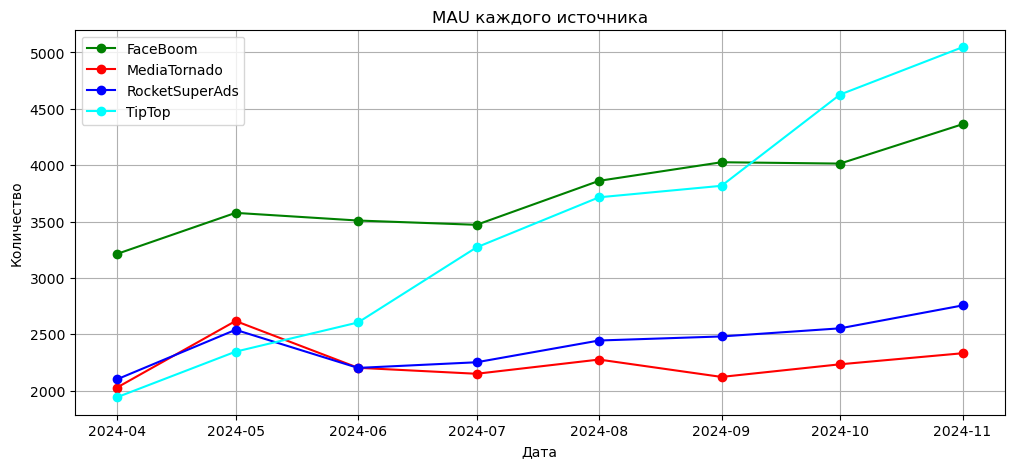

In [108]:
mau_channel = visits.groupby(['month', 'channel'])['user_id'].nunique().reset_index()

plt.subplots(figsize= (12, 5))

plt.plot(mau_channel[mau_channel['channel'] == 'FaceBoom']['month'], mau_channel[mau_channel['channel'] == 'FaceBoom']['user_id'], color= 'green', marker= 'o')
plt.plot(mau_channel[mau_channel['channel'] == 'MediaTornado']['month'], mau_channel[mau_channel['channel'] == 'MediaTornado']['user_id'], color= 'red', marker= 'o')
plt.plot(mau_channel[mau_channel['channel'] == 'RocketSuperAds']['month'], mau_channel[mau_channel['channel'] == 'RocketSuperAds']['user_id'], color= 'blue', marker= 'o')
plt.plot(mau_channel[mau_channel['channel'] == 'TipTop']['month'], mau_channel[mau_channel['channel'] == 'TipTop']['user_id'], color= 'cyan', marker= 'o')

plt.title('MAU каждого источника')
plt.xlabel('Дата')
plt.ylabel('Количество')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

На основе графика можно сделать следующие выводы:

`FaceBoom`:

- Количество MAU стабильно растет на протяжении всего периода, начиная с 3000 в апреле и достигая 4500 к ноябрю.
- Это указывает на успешное развитие платформы и увеличение её популярности.

`MediaTornado`:

- MAU нестабильно, сначала резкий рост до 2000 в мае, затем снижение до 1500 в июне, после чего постепенный рост до 2500 к ноябрю.
- Это может свидетельствовать о сезонных колебаниях или изменениях в стратегии привлечения пользователей.

`RocketSuperAds`:

- MAU увеличивается с 1500 в апреле до 2500 к ноябрю, показывая стабильный рост.
- Однако темпы роста ниже, чем у `FaceBoom`, что может указывать на меньшую популярность или более медленное развитие.

`TipTop`:

- Самый значительный рост среди всех источников: с 1500 в апреле до 4500 к ноябрю.
- Это говорит о высокой эффективности привлечения пользователей и быстром развитии платформы.



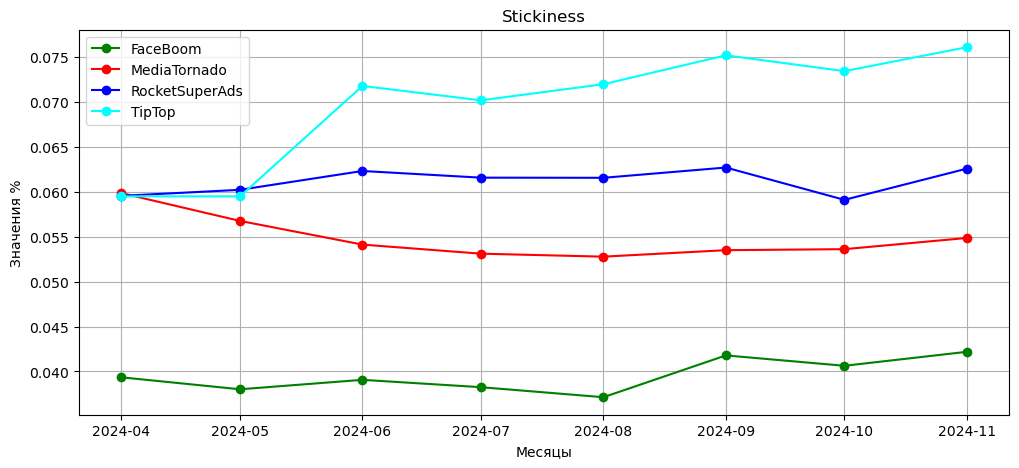

In [109]:
dau_channel['days'] = pd.to_datetime(dau_channel['days'])
dau_channel['month'] = dau_channel['days'].dt.to_period('M').dt.to_timestamp()

dau_channel_avg = dau_channel.groupby(['month','channel'])['user_id'].mean().reset_index()
stickiness_channel = pd.merge(mau_channel, dau_channel_avg, how= 'left', on= ['month','channel'])
stickiness_channel['stick'] = stickiness_channel['user_id_y'] / stickiness_channel['user_id_x']

plt.subplots(figsize=(12,5))

plt.plot(stickiness_channel[stickiness_channel['channel'] == 'FaceBoom']['month'], stickiness_channel[stickiness_channel['channel'] == 'FaceBoom']['stick'], color= 'green', marker= 'o')
plt.plot(stickiness_channel[stickiness_channel['channel'] == 'MediaTornado']['month'], stickiness_channel[stickiness_channel['channel'] == 'MediaTornado']['stick'], color= 'red', marker= 'o')
plt.plot(stickiness_channel[stickiness_channel['channel'] == 'RocketSuperAds']['month'], stickiness_channel[stickiness_channel['channel'] == 'RocketSuperAds']['stick'], color= 'blue', marker= 'o')
plt.plot(stickiness_channel[stickiness_channel['channel'] == 'TipTop']['month'], stickiness_channel[stickiness_channel['channel'] == 'TipTop']['stick'], color= 'cyan', marker= 'o')

plt.title('Stickiness')
plt.xlabel('Месяцы')
plt.ylabel('Значения %')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

На основе графика можно сделать следующие выводы:

- `MediaTornado` демонстрирует самую стабильную вовлеченность пользователей.
- `TipTop` и `FaceBoom` показывают значительное снижение вовлеченности, что может потребовать пересмотра стратегии.
- `RocketSuperAds` демонстрирует снижение, но затем стабилизацию, что может быть связано с изменениями в маркетинговой стратегии.

`TipTop`:
- Самый активный канал.
- Проявляет стабильный рост пользователей, что указывает на высокий интерес к продукту и потенциал окупаемости вложений в краткосрочной перспективе.

`FaceBoom`:
- Приходит много пользователей, но наблюдается единичное взаимодействие.
- Меньшая активность пользователей может указывать на долгий срок окупаемости или необходимость в улучшении вовлеченности.

`MediaTornado` и `RocketSuperAds`:
- Оба источника показывают менее выразительные результаты по сравнению с `TipTop`.

In [110]:
visits_28['interval'] = visits_28['first_dt'].dt.to_period('W').dt.to_timestamp()

# Считаем размер когорт на первый день
visits_first_day_28 = (visits_28[visits_28['lifetime'] == 0].groupby(['first_channel','interval']).agg(
  total_users = ('user_id','nunique')).reset_index()
)

# Считаем размер когорт на 14й и последующие дни
visits_n_days_28 = (visits_28[visits_28['lifetime'] >= 13].groupby(['first_channel','interval']).agg(
  n_days_users = ('user_id','nunique')).reset_index()
)

# Соединяем данные и считаем retention
retention_14_28 = visits_first_day_28.merge(visits_n_days_28, on=['first_channel','interval'], how='left').fillna(0)
retention_14_28['retention_14'] = retention_14_28['n_days_users'] / retention_14_28['total_users']

In [111]:
retention_14_28 = retention_14_28[retention_14_28['interval'] < '2024-11-01']

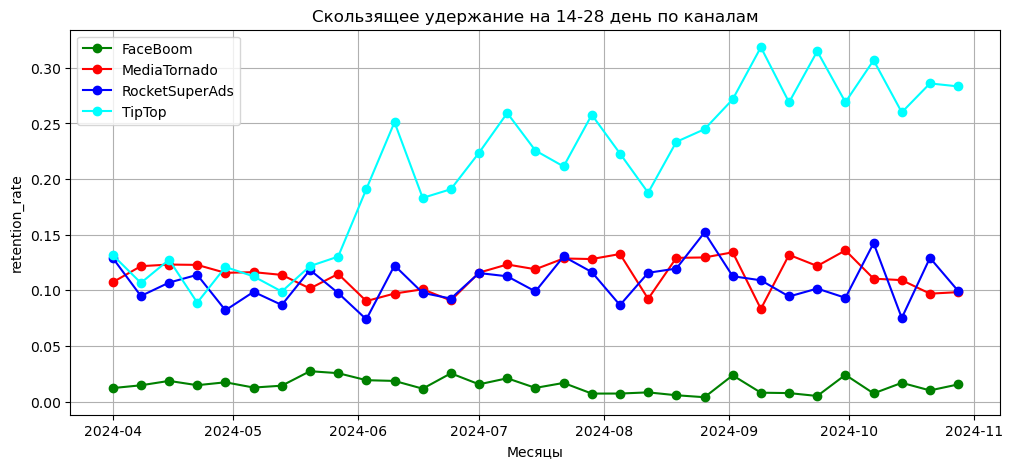

In [112]:
plt.subplots(figsize=(12,5))

plt.plot(retention_14_28[retention_14_28['first_channel'] == 'FaceBoom']['interval'], retention_14_28[retention_14_28['first_channel'] == 'FaceBoom']['retention_14'], color= 'green', marker= 'o')
plt.plot(retention_14_28[retention_14_28['first_channel'] == 'MediaTornado']['interval'], retention_14_28[retention_14_28['first_channel'] == 'MediaTornado']['retention_14'], color= 'red', marker= 'o')
plt.plot(retention_14_28[retention_14_28['first_channel'] == 'RocketSuperAds']['interval'], retention_14_28[retention_14_28['first_channel'] == 'RocketSuperAds']['retention_14'], color= 'blue', marker= 'o')
plt.plot(retention_14_28[retention_14_28['first_channel'] == 'TipTop']['interval'], retention_14_28[retention_14_28['first_channel'] == 'TipTop']['retention_14'], color= 'cyan', marker= 'o')

plt.title('Скользящее удержание на 14-28 день по каналам')
plt.xlabel('Месяцы')
plt.ylabel('retention_rate')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

На основе графика можно сделать следующие выводы:

- `TipTop` демонстрирует самый высокий уровень удержания в большинстве месяцев, что указывает на его эффективность.
- `MediaTornado` показывает значительный рост до ноября, но затем резкое падение, что может быть связано с сезонными факторами или изменениями в стратегии.
- `FaceBoom` и `RocketSuperAds` имеют более стабильные, но низкие показатели удержания.

В декабре все каналы, кроме `FaceBoom`, показывают значительное снижение удержания, что может быть связано с сезонным спадом активности.

In [113]:
# Считаем размер когорт на первый день
conversion_first_day_28 = (visits_28[visits_28['lifetime'] == 0].groupby(['first_channel','interval']).agg(
  total_users = ('user_id','nunique')).reset_index()
)

# Считаем размер когорт на 28й и последующие дни
conversion_n_day_28 = (visits_28[visits_28['lifetime'] == 27].groupby(['first_channel','interval']).agg(
  n_days_users = ('user_id','nunique')).reset_index()
)

# Соединяем данные и считаем retention
conversion_28 = conversion_first_day_28.merge(conversion_n_day_28, on=['first_channel','interval'], how='left').fillna(0)
conversion_28['conversion_28'] = conversion_28['n_days_users'] / conversion_28['total_users']

In [114]:
conversion_28 = conversion_28[conversion_28['interval'] < '2024-11-01']

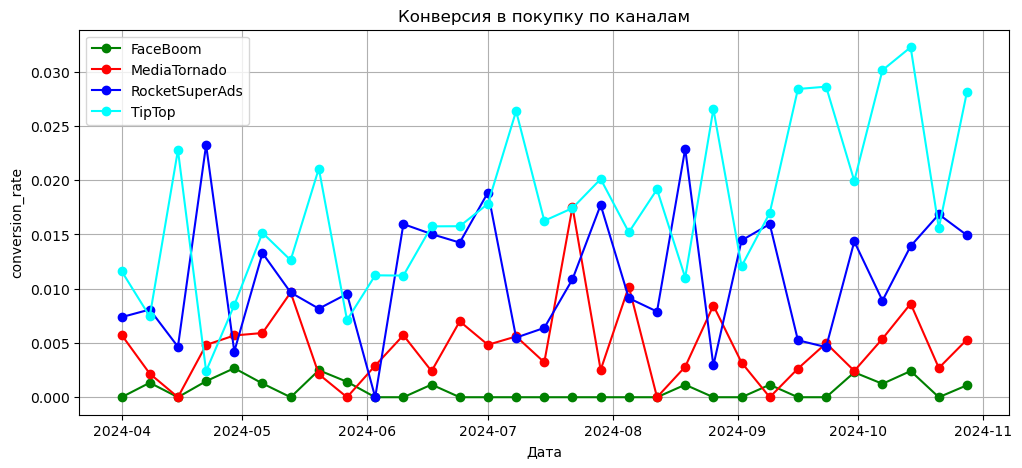

In [115]:
plt.subplots(figsize=(12,5))

plt.plot(conversion_28[conversion_28['first_channel'] == 'FaceBoom']['interval'], conversion_28[conversion_28['first_channel'] == 'FaceBoom']['conversion_28'], color= 'green', marker= 'o')
plt.plot(conversion_28[conversion_28['first_channel'] == 'MediaTornado']['interval'], conversion_28[conversion_28['first_channel'] == 'MediaTornado']['conversion_28'], color= 'red', marker= 'o')
plt.plot(conversion_28[conversion_28['first_channel'] == 'RocketSuperAds']['interval'], conversion_28[conversion_28['first_channel'] == 'RocketSuperAds']['conversion_28'], color= 'blue', marker= 'o')
plt.plot(conversion_28[conversion_28['first_channel'] == 'TipTop']['interval'], conversion_28[conversion_28['first_channel'] == 'TipTop']['conversion_28'], color= 'cyan', marker= 'o')

plt.title('Конверсия в покупку по каналам')
plt.xlabel('Дата')
plt.ylabel('conversion_rate')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

На основе графиков можно сделать следующие выводы:

- `MediaTornado` демонстрирует наиболее стабильный уровень конверсии с периодическими всплесками.
- `RocketSuperAds` показывает снижение конверсии к концу периода.
- `FaceBoom` имеет самый низкий уровень конверсии, но стабильный.
- `TipTop` демонстрирует значительные колебания, с резким падением в ноябре и декабре.



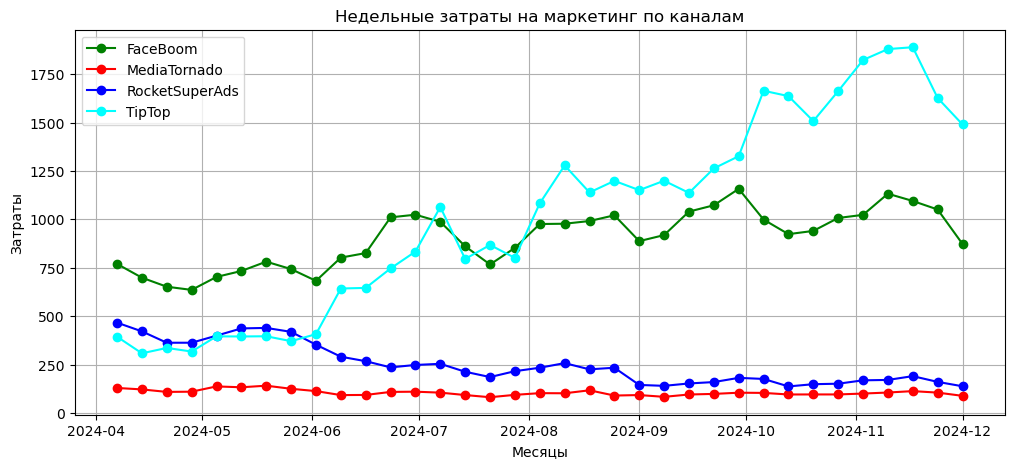

In [116]:
# Группируем затраты по неделям
weekly_costs = day_costs.groupby([
    pd.Grouper(key='dt', freq='W'),
    'channel'
]).agg(total_costs=('total_costs', 'sum')).reset_index()

plt.subplots(figsize=(12,5))

plt.plot(weekly_costs[weekly_costs['channel'] == 'FaceBoom']['dt'], weekly_costs[weekly_costs['channel'] == 'FaceBoom']['total_costs'], color= 'green', marker= 'o')
plt.plot(weekly_costs[weekly_costs['channel'] == 'MediaTornado']['dt'], weekly_costs[weekly_costs['channel'] == 'MediaTornado']['total_costs'], color= 'red', marker= 'o')
plt.plot(weekly_costs[weekly_costs['channel'] == 'RocketSuperAds']['dt'], weekly_costs[weekly_costs['channel'] == 'RocketSuperAds']['total_costs'], color= 'blue', marker= 'o')
plt.plot(weekly_costs[weekly_costs['channel'] == 'TipTop']['dt'], weekly_costs[weekly_costs['channel'] == 'TipTop']['total_costs'], color= 'cyan', marker= 'o')

plt.title('Недельные затраты на маркетинг по каналам')
plt.xlabel('Месяцы')
plt.ylabel('Затраты')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()


На основе графика можно сделать следующие выводы:

`FaceBoom`:

- В начале периода (апрель) затраты составляют около 500.
- Постепенно увеличиваются до 1000 в июле, затем снижаются до 750 в августе.
- В сентябре наблюдается рост до 1250, после чего затраты снижаются до 500 к декабрю.

`MediaTornado`:

- Затраты остаются стабильными на уровне около 100 на протяжении всего периода.

`RocketSuperAds`:

- В апреле и мае затраты составляют около 250.
- В июне наблюдается снижение до 100, затем в июле и августе затраты увеличиваются до 250.
- В сентябре и октябре затраты снижаются до 100, а в ноябре и декабре снова увеличиваются до 250.

`TipTop`:

- В апреле затраты составляют около 250.
- В мае наблюдается рост до 500, который сохраняется до июля.
- В августе затраты достигают пика в 1500, затем снижаются до 1000 в сентябре.
- В октябре и ноябре затраты снова растут до 1500, а в декабре снижаются до 1250.

Общие выводы:

- `TipTop` демонстрирует самые значительные колебания затрат, с пиками в августе и ноябре.
- `FaceBoom` показывает рост затрат в середине периода, но затем снижение к концу года.
- `MediaTornado` и `RocketSuperAds` имеют более стабильные затраты, с небольшими колебаниями.

В декабре наблюдается снижение затрат у всех каналов, кроме `RocketSuperAds`, что может быть связано с сезонными факторами.



In [117]:
first_session['first_week'] =  first_session['first_dt'].dt.to_period('W').dt.to_timestamp()
cac_channel = first_session.groupby(['first_week', 'first_channel']).agg(
  total_user= ('user_id', 'nunique'),
  avg_cac= ('cac', 'mean')
).reset_index()

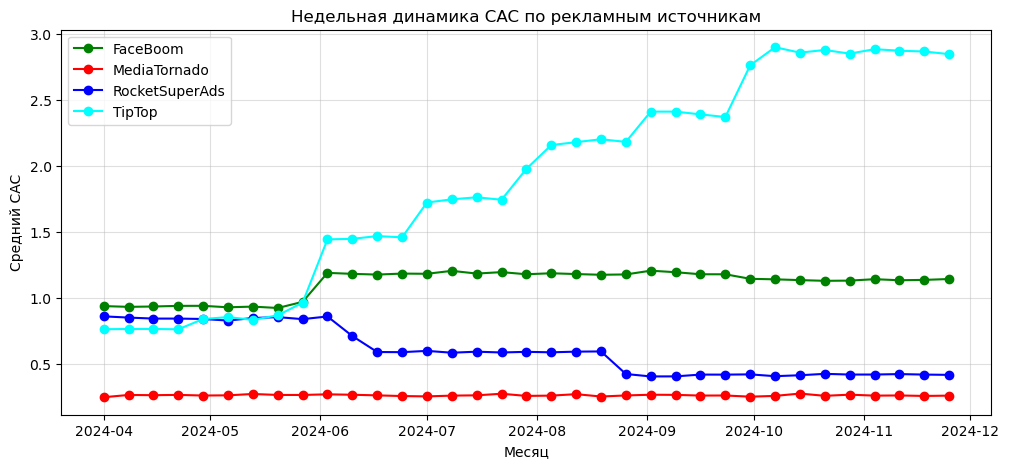

In [118]:
plt.subplots(figsize=(12,5))

plt.plot(cac_channel[cac_channel['first_channel'] == 'FaceBoom']['first_week'], cac_channel[cac_channel['first_channel'] == 'FaceBoom']['avg_cac'], color= 'green', marker= 'o')
plt.plot(cac_channel[cac_channel['first_channel'] == 'MediaTornado']['first_week'], cac_channel[cac_channel['first_channel'] == 'MediaTornado']['avg_cac'], color= 'red', marker= 'o')
plt.plot(cac_channel[cac_channel['first_channel'] == 'RocketSuperAds']['first_week'], cac_channel[cac_channel['first_channel'] == 'RocketSuperAds']['avg_cac'], color= 'blue', marker= 'o')
plt.plot(cac_channel[cac_channel['first_channel'] == 'TipTop']['first_week'], cac_channel[cac_channel['first_channel'] == 'TipTop']['avg_cac'], color= 'cyan', marker= 'o')

plt.title('Недельная динамика CAC по рекламным источникам')
plt.xlabel('Месяц')
plt.ylabel('Средний CAC')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid(alpha=.4)
plt.show()

Общие выводы:

- `TipTop` демонстрирует самый высокий рост САС, что может потребовать пересмотра стратегии.
- `FaceBoom` и `MediaTornado` остаются стабильными, что говорит о предсказуемости их эффективности.
- `RocketSuperAds` показывает снижение САС в июне, что может быть положительным изменением, но требует дальнейшего анализа.

In [119]:
ltv_channel = orders[orders['lifetime'] < 28].copy()
ltv_channel['first_week'] = ltv_channel['first_dt'].dt.to_period('W').dt.to_timestamp()

ltv_channel = ltv_channel.groupby(['first_channel', 'first_week']).agg(
  revenue_28_channel= ('revenue','sum'),
).reset_index()

ltv_channel = ltv_channel.merge(cac_channel, on= ['first_channel', 'first_week'])
ltv_channel['ltv_28_channel'] = ltv_channel['revenue_28_channel'] / ltv_channel['total_user']

In [120]:
ltv_channel = ltv_channel[ltv_channel['first_week'] < '2024-11-01']

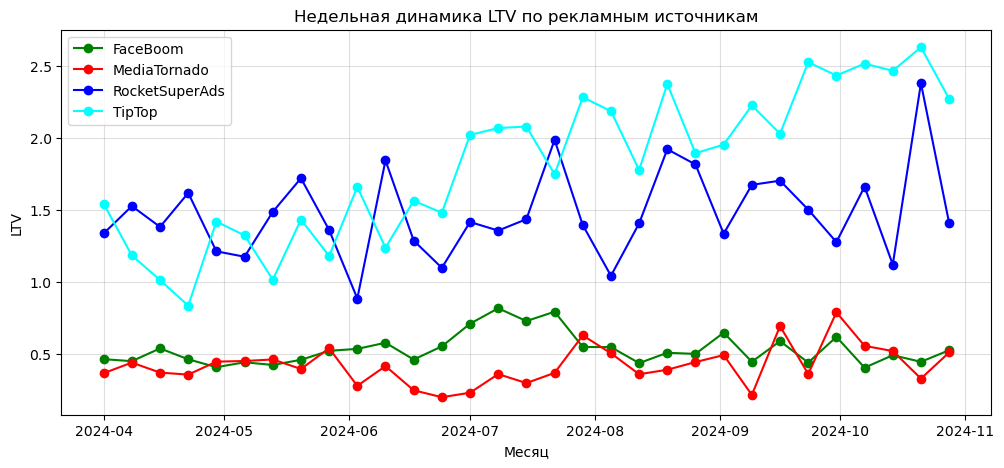

In [121]:
plt.subplots(figsize=(12,5))

plt.plot(ltv_channel[ltv_channel['first_channel'] == 'FaceBoom']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'FaceBoom']['ltv_28_channel'], color= 'green', marker= 'o')
plt.plot(ltv_channel[ltv_channel['first_channel'] == 'MediaTornado']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'MediaTornado']['ltv_28_channel'], color= 'red', marker= 'o')
plt.plot(ltv_channel[ltv_channel['first_channel'] == 'RocketSuperAds']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'RocketSuperAds']['ltv_28_channel'], color= 'blue', marker= 'o')
plt.plot(ltv_channel[ltv_channel['first_channel'] == 'TipTop']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'TipTop']['ltv_28_channel'], color= 'cyan', marker= 'o')

plt.title('Недельная динамика LTV по рекламным источникам')
plt.xlabel('Месяц')
plt.ylabel('LTV')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid(alpha=.4)
plt.show()

На графике представлена недельная динамика LTV по рекламным источникам за период с апреля по ноябрь 2024 года. Вот основные выводы:

- `FaceBoom`: LTV демонстрирует стабильный рост с апреля по октябрь, с пиком в октябре (около 1,5). В ноябре наблюдается снижение до уровня 1,0.
- `MediaTornado`: LTV остается относительно стабильным на уровне 0,5–0,6 в течение всего периода.
- `RocketSuperAds`: LTV колеблется, с пиками в мае, июле и октябре (около 2,0). В ноябре наблюдается снижение до 1,5.
- `TipTop`: LTV показывает значительные колебания, с пиками в июне, августе и ноябре (около 2,0). В октябре наблюдается снижение до 1,5.

Общие выводы:

- `FaceBoom` и `TipTop` демонстрируют наиболее высокую эффективность с периодами значительного роста LTV.
- `RocketSuperAds` показывает стабильный рост в конце года, что может быть связано с сезонными факторами.
- `MediaTornado` остается наименее эффективным каналом на протяжении всего периода.



In [122]:
ltv_channel['roi_28_channel'] = (ltv_channel['ltv_28_channel'] - ltv_channel['avg_cac']) / ltv_channel['avg_cac']

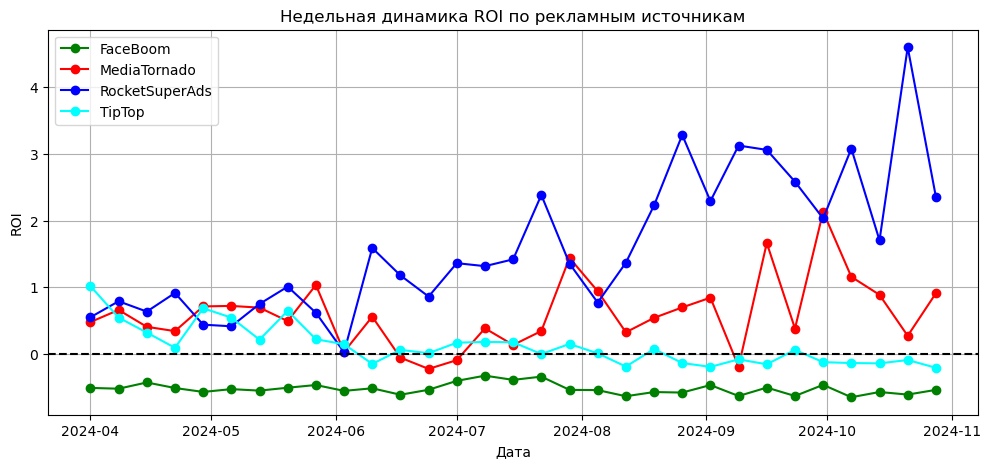

In [123]:
plt.subplots(figsize= (12, 5))

plt.plot(ltv_channel[ltv_channel['first_channel'] == 'FaceBoom']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'FaceBoom']['roi_28_channel'], color= 'green', marker= 'o')
plt.plot(ltv_channel[ltv_channel['first_channel'] == 'MediaTornado']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'MediaTornado']['roi_28_channel'], color= 'red', marker= 'o')
plt.plot(ltv_channel[ltv_channel['first_channel'] == 'RocketSuperAds']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'RocketSuperAds']['roi_28_channel'], color= 'blue', marker= 'o')
plt.plot(ltv_channel[ltv_channel['first_channel'] == 'TipTop']['first_week'], ltv_channel[ltv_channel['first_channel'] == 'TipTop']['roi_28_channel'], color= 'cyan', marker= 'o')
plt.axhline(y= 0, color= 'black', linestyle= '--', label= 'Граница окупаемости')

plt.title('Недельная динамика ROI по рекламным источникам')
plt.xlabel('Дата')
plt.ylabel('ROI')

plt.legend(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'])
plt.grid()
plt.show()

Рекомендации:

- Уделить внимание оптимизации вложений в FaceBoom, так как ROI практически отсутствует.
- Проанализировать причины падения ROI у MediaTornado в ноябре и скорректировать стратегию.
- Продолжить использовать RocketSuperAds, так как он показывает наилучшие результаты.
- Рассмотреть возможность увеличения бюджета на TipTop в периоды, когда ROI выше среднего.


## Анализ периода окупаемости маркетинговых вложений

Для источников, которые к 28-му дню не выходят на уровень окупаемости, рассчитайте и визуализируйте в виде тепловой карты значения ROI за больший период, например за 8–10 недель.

Разделите данные на недельные когорты по дате привлечения, в качестве интервала наблюдений используйте недели.

Сделайте вывод о том, за какой период окупаются вложения в эти источники.

In [124]:
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)
orders_all = orders.copy()

orders_all['first_week'] = orders_all['first_dt'].dt.to_period('W').dt.to_timestamp()
orders_all['week'] = orders_all['event_dt'].dt.to_period('W').dt.to_timestamp()

In [125]:
# Рассчитаем разницу между минимальной датой и текущей датой в неделях
orders_all['N_week'] = (orders_all['week'] - orders_all['first_week']).dt.days / 7
# Суммируем revenue для каждой недели
orders_all = orders_all.groupby(['first_channel', 'first_week', 'N_week'])['revenue'].sum().reset_index()

orders_all = orders_all.sort_values(by=['first_channel', 'N_week'])
# Посчитаем кумулятивную выручку для каждой недели
orders_all['cum_revenue'] = orders_all.groupby(['first_channel','first_week'])['revenue'].cumsum()

In [126]:
# Считаем размер когорт
channel_cohort_size = first_session.copy()
channel_cohort_size['first_week'] = channel_cohort_size['first_dt'].dt.to_period('W').dt.to_timestamp()

channel_cohort_size = channel_cohort_size.groupby(['first_channel','first_week']).agg({'user_id':'nunique','cac':'mean'}).reset_index()
channel_cohort_size.columns = ['first_channel', 'first_week', 'total_users', 'cac']

In [127]:
# Добавим размер когорт и стоимость одного пользователя
orders_all = orders_all.merge(channel_cohort_size, on=['first_channel','first_week'])
orders_all['ltv'] = orders_all['cum_revenue'] / orders_all['total_users']

# Считаем ROI
orders_all['roi'] = (orders_all['ltv'] - orders_all['cac']) / orders_all['cac']

In [128]:
# Строим карту для TipTop
tiptop = orders_all[(orders_all['first_channel'] == 'TipTop') & (orders_all['N_week'] < 8)]

# Пивотируем данные, чтобы first_week были индексами, а N_week - столбцами
tiptop_pp = tiptop.pivot(index='first_week', columns='N_week', values='roi')
tiptop_pp.index = np.datetime_as_string(tiptop_pp.index, unit='D')

In [129]:
# Строим карту для FaceBoom
faceboom = orders_all[(orders_all['first_channel'] == 'FaceBoom') & (orders_all['N_week'] < 8)]

# Пивотируем данные, чтобы first_week были индексами, а N_week - столбцами
faceboom_pp = faceboom.pivot(index='first_week', columns='N_week', values='roi')
faceboom_pp.index = np.datetime_as_string(faceboom_pp.index, unit='D')

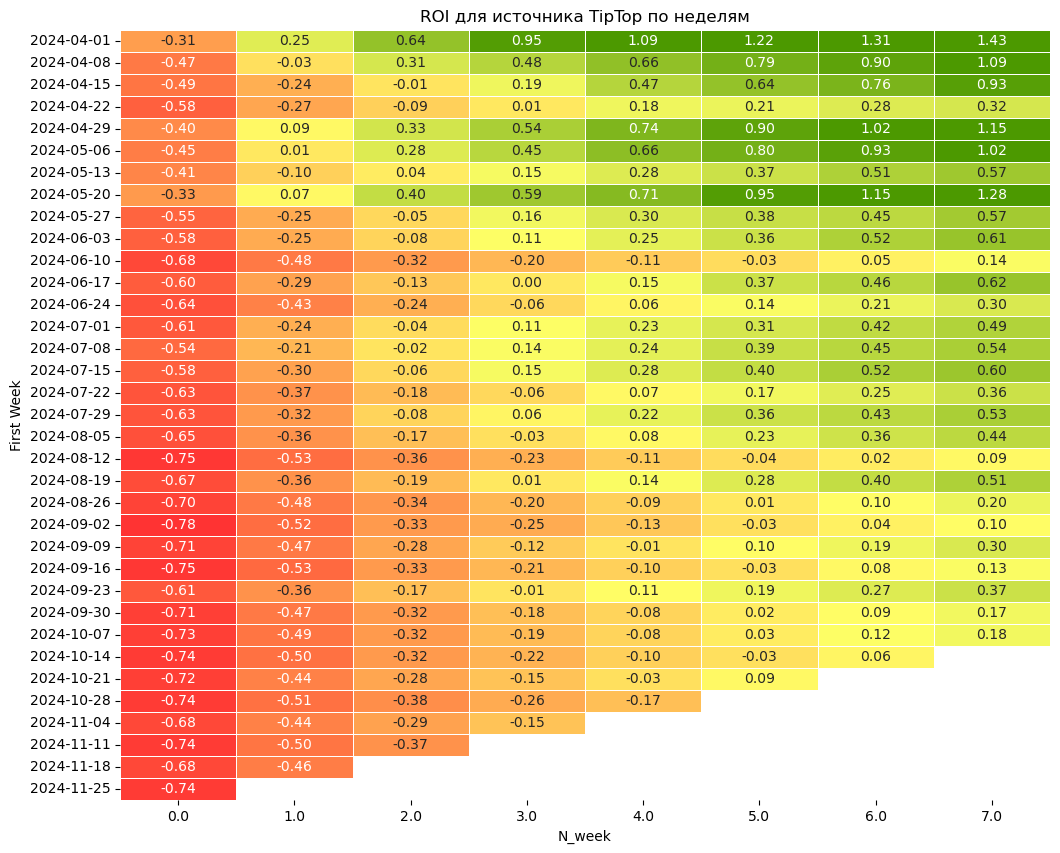

In [130]:
# Строим heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(tiptop_pp,
        annot=True,
        fmt='.2f',
        linewidths=0.5, linecolor='white',
        vmax=1, cmap= cmap,
        cbar=False)

plt.title('ROI для источника TipTop по неделям')
plt.xlabel('N_week')
plt.ylabel('First Week')
plt.show()

Для того чтобы сделать вывод о периоде окупаемости вложений, необходимо проанализировать, когда ROI становится положительным и остается таковым на протяжении определенного времени. В данном случае видно, что:

- В начале периода (2024-04-01) ROI отрицательный (-0.31).
- К середине периода (2024-05-06) ROI становится положительным (0.45).
- В дальнейшем ROI продолжает оставаться положительным, что указывает на окупаемость вложений.

Таким образом, можно сделать вывод, что вложения в источник TipTop начинают окупаться примерно через 5 недель после начала периода.

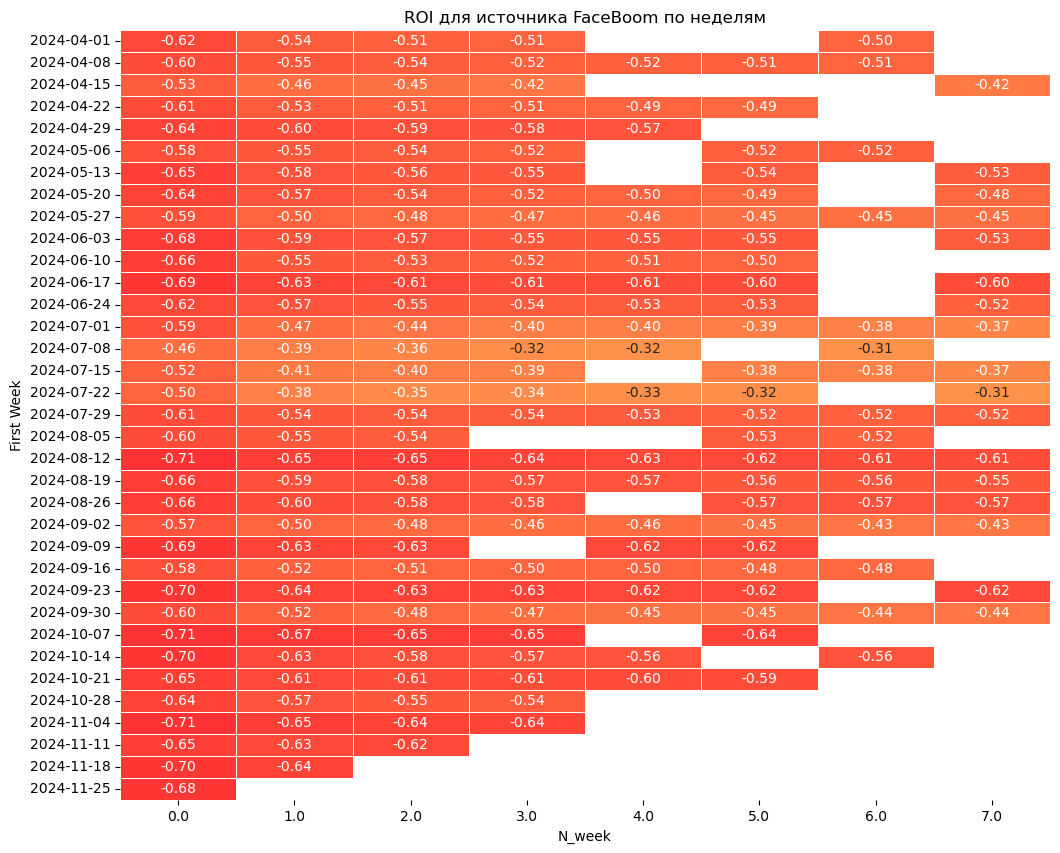

In [131]:
# Строим heatmap
plt.figure(figsize=(12, 10))

sns.heatmap(faceboom_pp,
        annot=True,
        fmt='.2f',
        linewidths=0.5, linecolor='white',
        vmax=1, cmap= cmap,
        cbar=False)

plt.title('ROI для источника FaceBoom по неделям')
plt.xlabel('N_week')
plt.ylabel('First Week')
plt.show()

Вложения в источник FaceBoom не окупаются в течение периода до 7 недель, представленного на графике. Следует либо пересмотреть стратегию инвестирования в этот источник, либо искать другие источники с положительным ROI.

## Выводы и рекомендации

Сформулируйте общий вывод. Зафиксируйте основные результаты и инсайты. Например, охарактеризуйте аудиторию продукта, покажите распределение маркетинговых затрат по каналам привлечения, опишите каждый канал привлечения. Делайте акцент на сильных и слабых сторонах. Укажите, какие каналы привлечения не вышли на окупаемость и по каким причинам.

Дайте рекомендации отделу маркетинга: опишите, как повысить эффективность вложений в рекламу.


# Общий анализ эффективности маркетинговых каналов

Характеристика аудитории продукта:

Целевая аудитория демонстрирует устойчивый рост активности, что подтверждается увеличением показателей DAU и MAU на протяжении всего периода наблюдения. Наибольшую активность пользователи проявляют в конце года, что может быть связано с сезонными факторами.

Распределение маркетинговых затрат
Основные каналы привлечения и их эффективность:
- TipTop — лидер по количеству привлеченных пользователей (30 000), но демонстрирует высокие затраты и колебания в ROI
- RocketSuperAds — второй по эффективности канал (25 000 пользователей), показывает стабильный рост и высокий ROI
- FaceBoom и MediaTornado — менее эффективные каналы с 15 000 пользователей каждый

Анализ эффективности каналов
Сильные стороны:
- TipTop — высокий уровень удержания пользователей
- RocketSuperAds — стабильный рост MAU и высокий ROI
- MediaTornado — стабильная конверсия

Слабые стороны:
- FaceBoom — низкий ROI и нестабильная вовлеченность
- TipTop — высокие затраты и колебания LTV
- MediaTornado — низкий LTV

Проблемы и риски
Ключевые проблемы:
- Снижение ROI в конце периода
- Колебания показателей LTV
- Нестабильность вовлеченности в некоторых каналах
- Рост САС в большинстве каналов

Рекомендации по оптимизации
Стратегические рекомендации:
- Перераспределить бюджет в пользу RocketSuperAds как наиболее эффективного канала
- Оптимизировать затраты на TipTop при сохранении его лидирующих позиций
- Провести аудит эффективности FaceBoom и рассмотреть возможность сокращения бюджета
- Усилить работу с MediaTornado для повышения LTV

Тактические меры:
- Внедрить систему мониторинга сезонных колебаний
- Оптимизировать рекламные кампании в периоды пиковой активности
- Провести анализ причин снижения ROI и разработать корректирующие меры
- Разработать стратегию удержания пользователей для снижения оттока




